# Estimation de la valeur nominale d'un capteur de vibrations pour maintenance prédictive
Ce notebook présente les différentes méthodes employées pour l'obtention de la valeur nominale d'un capteur de vibration.

## Import des bibliothèques utiles

In [1]:
# Manipulation de données, calcul et visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from scipy import stats
import sklearn
from sklearn.cluster import KMeans

from functools import reduce


## Chargement des données

Les données sont issues d'un capteur de vibrations et ont été collectées sur 20 jours.  
* spie_iot_exte_mesu.csv contient les différents canaux du capteur
* spie_iot_exte_vale.csv contient les valeurs associées à ces canaux (exemple 3011/3012/3013 pour X/Y/Z…)

On peut également utiliser les données mises à jour à date du 15 juillet, il suffit de commenter/décommenter les lignes en question.

In [2]:
#filename_mesu = '15072021_spie_iot_exte_mesu.csv'
#filename_vale = '15072021_spie_iot_exte_vale.csv'

filename_mesu = 'spie_iot_exte_mesu.csv'
filename_vale = 'spie_iot_exte_vale.csv'

## Exploration des données

In [3]:
df_mesu = pd.read_csv(f'data/{filename_mesu}', sep=';')
df_mesu.head(3)

,C_Mesu,T_Mesu,C_Equi,T_Type,T_Unit
0,3023,Ultrason CFCTR,61,decimal,NaN
1,3022,Température TOTAL,61,decimal,°C
2,3021,Vibration TOTAL,61,decimal,mm/s


In [4]:
df_vale = pd.read_csv(f'data/{filename_vale}', sep=';')
df_vale.head(3)

,C_Vale,C_Mesu,D_Vale,N_Vale,L_Etat
0,1153319,3023,2021-05-28 15:34:41,1.34694,1
1,1153320,3023,2021-05-28 16:49:41,1.38000,1
2,1153321,3023,2021-05-28 17:49:42,1.40000,1


In [5]:
print('Informations Dataset Mesu :')
print(df_mesu.info())

Informations Dataset Mesu :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   C_Mesu  17 non-null     int64 
 1   T_Mesu  17 non-null     object
 2   C_Equi  17 non-null     int64 
 3   T_Type  17 non-null     object
 4   T_Unit  15 non-null     object
dtypes: int64(2), object(3)
memory usage: 808.0+ bytes
None


On a donc 5 colonnes et 17 lignes.  
Il y a deux canaux qui n'ont pas d'unité.

In [6]:
df_mesu[df_mesu['T_Unit'].isnull() == True]

,C_Mesu,T_Mesu,C_Equi,T_Type,T_Unit
0,3023,Ultrason CFCTR,61,decimal,NaN
4,3019,Magnitude Y,61,decimal,NaN


In [7]:
print('Informations Dataset Vale :')
print(df_vale.info())

Informations Dataset Vale :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2784 entries, 0 to 2783
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   C_Vale  2784 non-null   int64  
 1   C_Mesu  2784 non-null   int64  
 2   D_Vale  2784 non-null   object 
 3   N_Vale  2784 non-null   float64
 4   L_Etat  2784 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 108.9+ KB
None


On a 5 colonnes pour 2 784 lignes, il n'y a pas de valeur manquante. Toutes les variables sont des entiers sauf D_Vale qui est une date et N_Vale qui est un nombre flottant.  
On modifie la colonne de la D_Vale pour avoir un format de date plus facile à manipuler.

In [8]:
# Les deux fichiers ont des formats de date différents.
# Afin d'éviter les erreurs liées au parsing de la date, on teste plusieurs formats de date différents
# Le temps de calcul de cette méthode est plus court que lorsque l'on essaie de convertir directement avec les outils pandas
formats = ['%Y-%m-%d %H:%M:%S.%f','%d/%m/%Y %H:%M', '%m/%d/%Y  %H:%M:%S', '%d-%m-%y', '%d-%m-%Y', '%Y-%m-%d', '%b %y', '%B %Y', '%d %B %Y']
df_vale['D_Vale'] = reduce(lambda l, r: l.combine_first(r), [pd.to_datetime(df_vale['D_Vale'], format=fmt, errors='coerce') for fmt in formats])


In [9]:
print(df_vale.dtypes)

C_Vale             int64
C_Mesu             int64
D_Vale    datetime64[ns]
N_Vale           float64
L_Etat             int64
dtype: object


La modification a bien été appliquée.

# Visualisation des données

In [10]:
def plot_mesures(mesures):
    tot = len(mesures)
    cols = 2
    rows = tot //cols
    rows += tot % cols
    pos = range(1, tot + 1)
    fig = plt.figure(figsize=(20, 20))
    for mesure, k in zip(mesures, range(tot)):
        try:
            df_tmp = df_vale[df_vale['C_Mesu']==(mesure)]
            title = f'{df_mesu[df_mesu["C_Mesu"]==int(mesure)].T_Mesu.item()}'
            xlabel = 'Date'
            ylabel = f'{df_mesu[df_mesu["C_Mesu"]==int(mesure)].T_Mesu.item()} en {df_mesu[df_mesu["C_Mesu"]==int(mesure)].T_Unit.item()}'
            ax = fig.add_subplot(rows, cols, pos[k])
            ax = plt.scatter(df_tmp['D_Vale'], df_tmp['N_Vale'])
            plt.title(title, loc='center')
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
        except:
            pass
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)
    plt.show()

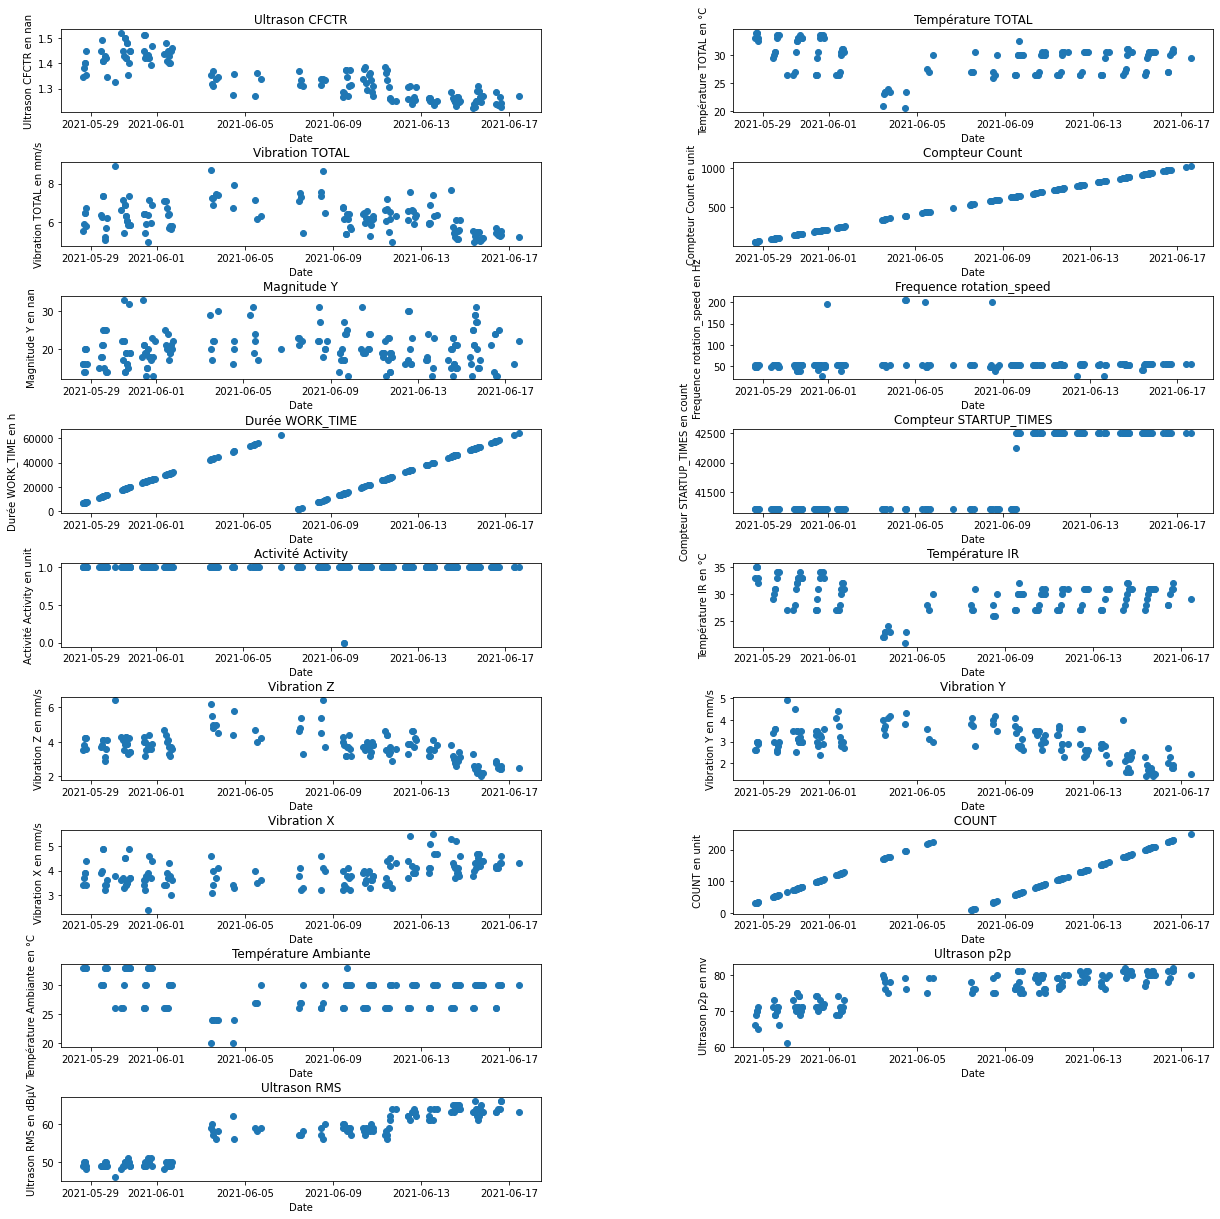

In [11]:
C_Mesu = df_vale.C_Mesu.unique()
plot_mesures(C_Mesu)

In [12]:
def boxplot_mesures(mesures):
    tot = len(mesures)
    cols = 2
    rows = tot //cols
    rows += tot % cols
    pos = range(1, tot + 1)
    fig = plt.figure(figsize=(20, 20))
    for mesure, k in zip(mesures, range(tot)):
        try:
            df_tmp = df_vale[df_vale['C_Mesu']==(mesure)]
            df_tmp = df_tmp.reset_index()
            title = f'{df_mesu[df_mesu["C_Mesu"]==int(mesure)].T_Mesu.item()}'
            xlabel = 'Date'
            ylabel = f'{df_mesu[df_mesu["C_Mesu"]==int(mesure)].T_Mesu.item()} en {df_mesu[df_mesu["C_Mesu"]==int(mesure)].T_Unit.item()}'
            ax = fig.add_subplot(rows, cols, pos[k])
            ax = sns.boxplot(data=df_tmp['N_Vale'])
            plt.title(title, loc='center')
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
        except:
            pass
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)
    plt.show()

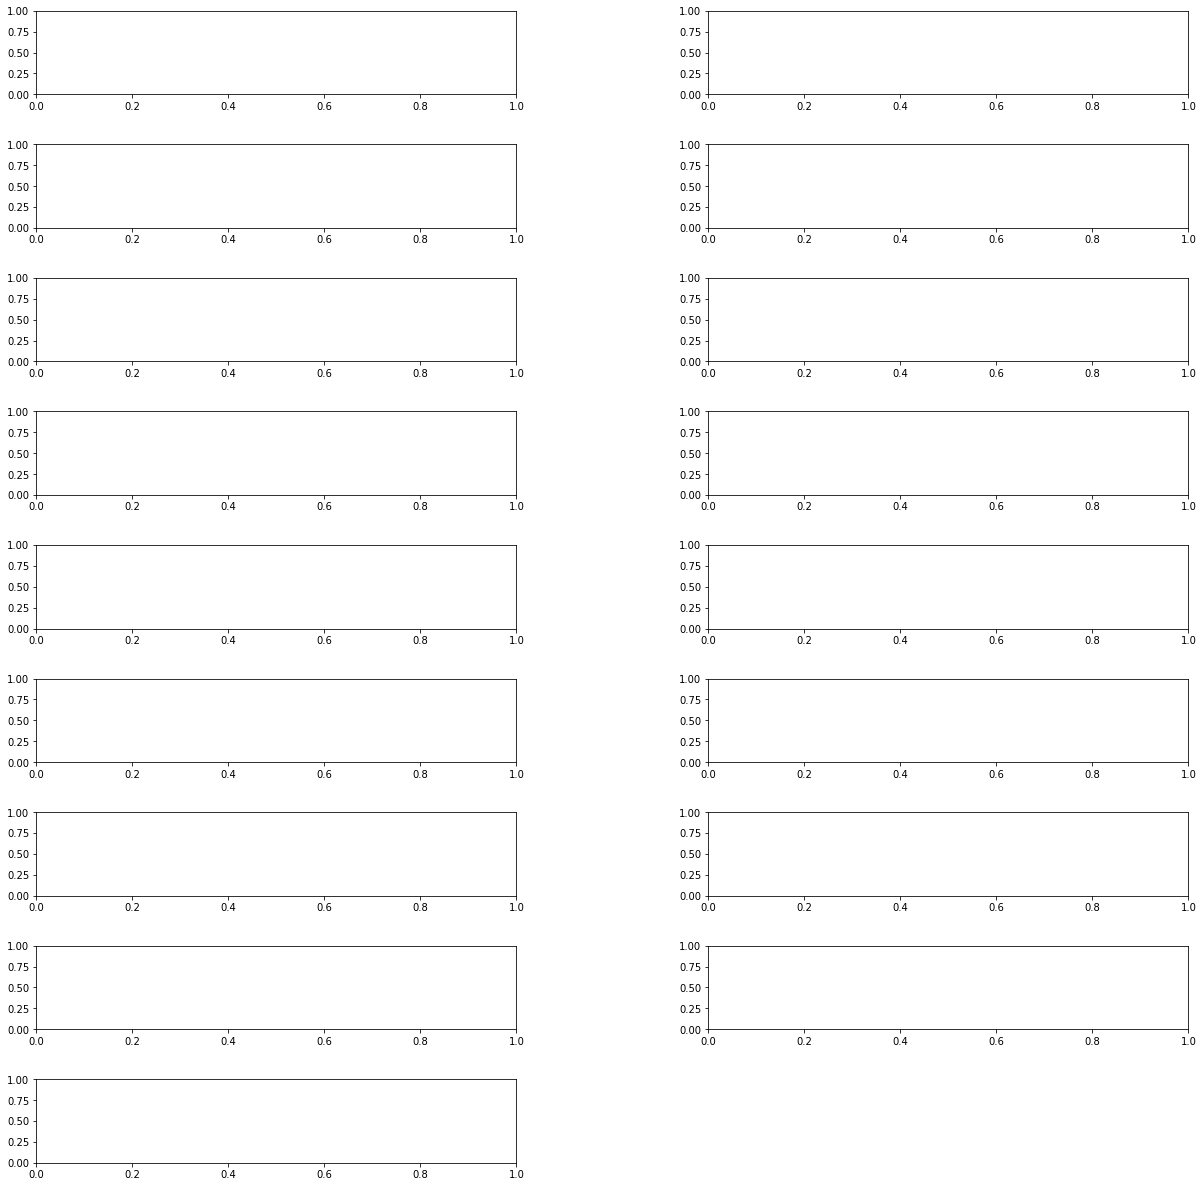

In [13]:
boxplot_mesures(C_Mesu)

Les boites à moustaches (boxplot) permettent de mettre en évidence la distribution des données. Ici, on peut voir que l'on a quelques valeurs aberrantes (outliers) en Vibration TOTAL/X/Z, Magnitude Y, Activité Activity et Frequence rotation_speed. Les valeurs aberrantes peuvent fausser la valeur nominale du capteur et peuvent parfois être dues à des erreurs de mesures.

## Préparation des données
Pour faciliter l'utilisation des données dans notre modèle, on va d'abord créer un dataset organisé par date et avec les différentes mesures en colonnes.

In [14]:
# On récupère les dates / heures de relevés
df = df_vale.loc[:, ['D_Vale']].copy()

In [15]:
# On supprime les dates qui sont en double s'il y en a 
df = df.drop_duplicates()

In [16]:
# On utilise les dates pour indexer le dataframe
df = df.set_index('D_Vale')

In [17]:
# On récupère les colonnes (nom des différentes mesures)
columns = []
for i in range(len(df_mesu.T_Mesu)):
    columns.append(df_mesu.T_Mesu[i])

In [18]:
# Les colonnes sont ajoutées à notre dataframe et on initialise à 0 les valeurs du dataframe
for c in columns:
    df[c] = 0

In [19]:
# Former un dictionnaire associant le code et le nom de la mesure
dict_c_mesu = {}
for i, r in df_mesu.iterrows():
    dict_c_mesu[r['C_Mesu']] = r['T_Mesu']

In [20]:
# Fonction pour récupérer la valeur de la mesure à partir de son nom
def get_key(dico, val):
    for key, value in dico.items():
         if val == value:
            return key
 
    return False

In [21]:
# Remplir le dataframe avec les données correspondantes 
for index, row in df_vale.iterrows():
    try:

        col = (dict_c_mesu[int(row["C_Mesu"])])
        df.loc[row["D_Vale"], col] = (row["N_Vale"])
    except:
        pass
df.head(3)

,Ultrason CFCTR,Température TOTAL,Vibration TOTAL,Compteur Count,Magnitude Y,Frequence rotation_speed,Durée WORK_TIME,Compteur STARTUP_TIMES,Activité Activity,Température IR,Vibration Z,Vibration Y,Vibration X,COUNT,Température Ambiante,Ultrason p2p,Ultrason RMS
D_Vale,,,,,,,,,,,,,,,,,
2021-05-28 15:34:41,1.34694,33.0,5.52901,0,0,0,0,0,1,33,3.5,2.6,3.4,31,33,66,49
2021-05-28 16:49:41,1.38000,34.0,5.90678,0,0,0,0,0,1,35,3.8,2.6,3.7,32,33,69,50
2021-05-28 17:49:42,1.40000,34.0,6.46916,0,0,0,0,0,1,35,4.2,3.0,3.9,33,33,70,50


On peut voir que toutes les métriques ne sont pas relevées aux mêmes intervalles temporels. Les métriques qui nous intéressent le plus ont les mêmes fréquences de relevé. Pour éviter les 0 on va regrouper les métriques ayant les mêmes intervalles de relevés. 

In [22]:
# On récupère les colonnes qui ont une fréquence de relevé similaire.
col_compteur = ['Compteur Count', 'Magnitude Y', 'Frequence rotation_speed', 'Durée WORK_TIME', 'Compteur STARTUP_TIMES']
# On copie le contenu de ces colonnes dans un nouveau dataframe
df_compteurs = df.loc[:, col_compteur].copy()
# On converti ces valeurs en float
df_compteurs = df_compteurs.astype('float')
# On ne garde que les valeurs qui sont non nulles 
df_compteurs = df_compteurs[(df_compteurs)>0].copy()
df_compteurs = df_compteurs.dropna()
df_compteurs.head(3)

,Compteur Count,Magnitude Y,Frequence rotation_speed,Durée WORK_TIME,Compteur STARTUP_TIMES
D_Vale,,,,,
2021-05-28 15:04:41,61.0,16.0,52.0,6656.0,41216.0
2021-05-28 15:29:41,63.0,16.0,48.0,6656.0,41216.0
2021-05-28 16:09:41,63.0,16.0,48.0,6912.0,41216.0


In [23]:
# On supprime les colonnes que l'on a déjà utilisées
df_donnees = df.drop(columns=col_compteur)
# Conversion en float
df_donnees = df_donnees.astype('float')
# Suppression des données non définies
df_donnees = df_donnees[df_donnees['Ultrason CFCTR']>0].copy()
df_donnees.head(3)

,Ultrason CFCTR,Température TOTAL,Vibration TOTAL,Activité Activity,Température IR,Vibration Z,Vibration Y,Vibration X,COUNT,Température Ambiante,Ultrason p2p,Ultrason RMS
D_Vale,,,,,,,,,,,,
2021-05-28 15:34:41,1.34694,33.0,5.52901,1.0,33.0,3.5,2.6,3.4,31.0,33.0,66.0,49.0
2021-05-28 16:49:41,1.38000,34.0,5.90678,1.0,35.0,3.8,2.6,3.7,32.0,33.0,69.0,50.0
2021-05-28 17:49:42,1.40000,34.0,6.46916,1.0,35.0,4.2,3.0,3.9,33.0,33.0,70.0,50.0


In [24]:
# Export de ces données au format .csv
df_donnees.to_csv(f'data/{filename_mesu}_donnees_capteurs.csv')

In [25]:
def compute_z_score(column):
    z = np.abs(stats.zscore(column))
    return z

Détection des valeurs aberrantes avec le score z.

In [26]:
threshold = 3
for k, v in dict_c_mesu.items():
    if v in df_donnees.columns:
        z = compute_z_score(df_donnees[v])
        print(f'Outliers positions {v}: {np.where(z > threshold)}')
    elif v in df_compteurs.columns:
        z = compute_z_score(df_compteurs[v])
        print(f'Outliers positions {v}: {np.where(z > threshold)}')
    else:
        print(f'Column "{v}" not found.')

Outliers positions Ultrason CFCTR: (array([], dtype=int64),)
Outliers positions Température TOTAL: (array([53], dtype=int64),)
Outliers positions Vibration TOTAL: (array([14, 47, 64], dtype=int64),)
Outliers positions Compteur Count: (array([], dtype=int64),)
Outliers positions Magnitude Y: (array([], dtype=int64),)
Outliers positions Frequence rotation_speed: (array([51, 68, 69, 72, 85], dtype=int64),)
Outliers positions Durée WORK_TIME: (array([], dtype=int64),)
Outliers positions Compteur STARTUP_TIMES: (array([], dtype=int64),)
Outliers positions Activité Activity: (array([69], dtype=int64),)
Outliers positions Température IR: (array([53], dtype=int64),)
Outliers positions Vibration Z: (array([14, 64], dtype=int64),)
Outliers positions Vibration Y: (array([], dtype=int64),)
Outliers positions Vibration X: (array([108], dtype=int64),)
Outliers positions  COUNT: (array([], dtype=int64),)
Outliers positions Température Ambiante: (array([47, 53], dtype=int64),)
Outliers positions Ultra

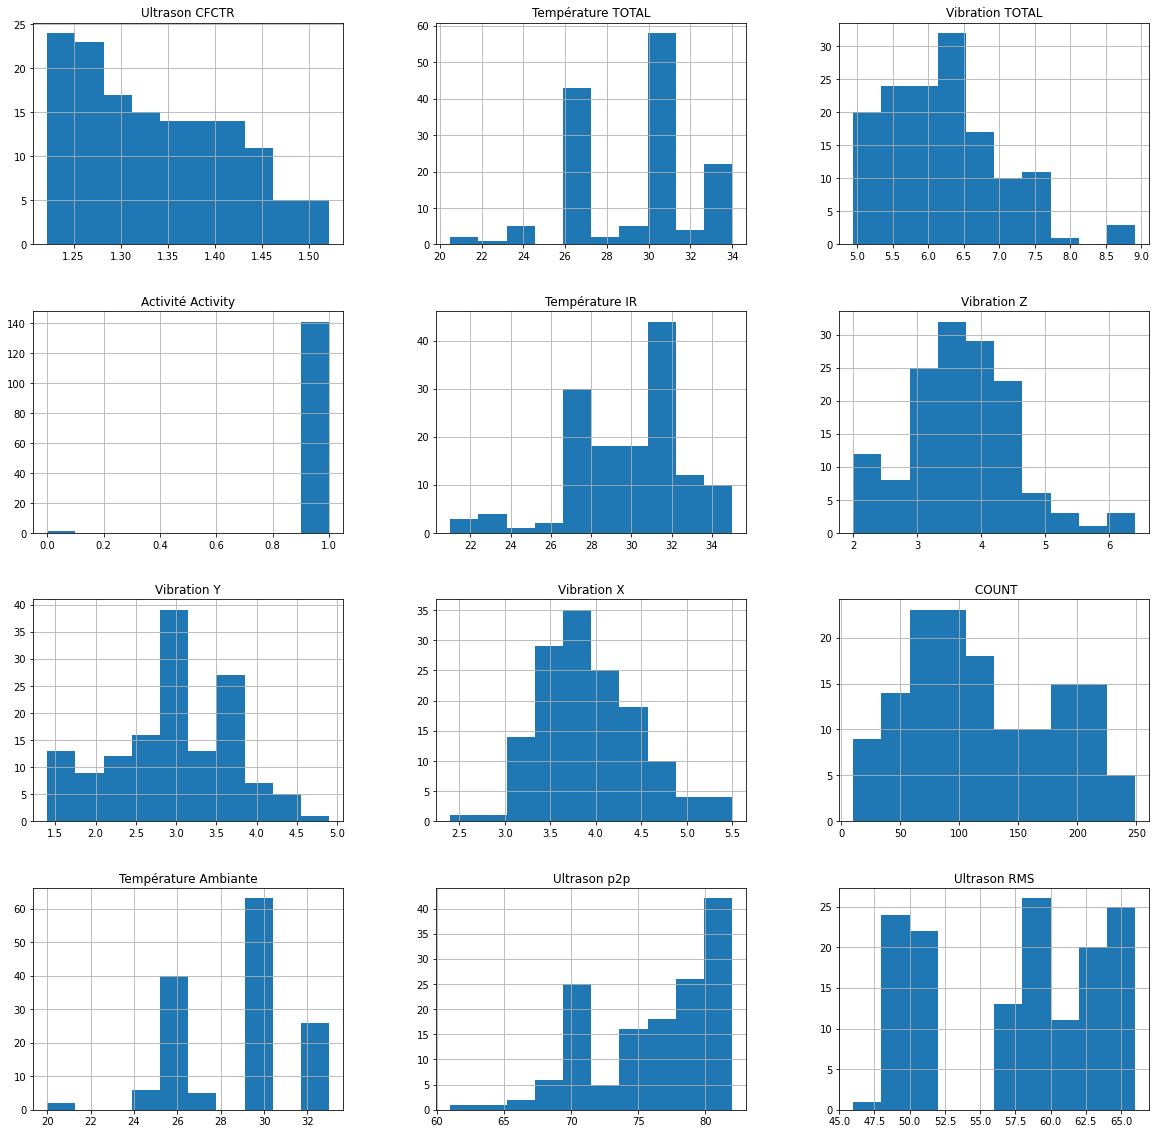

In [27]:
histogram = df_donnees.hist(figsize = (20,20))
plt.show()

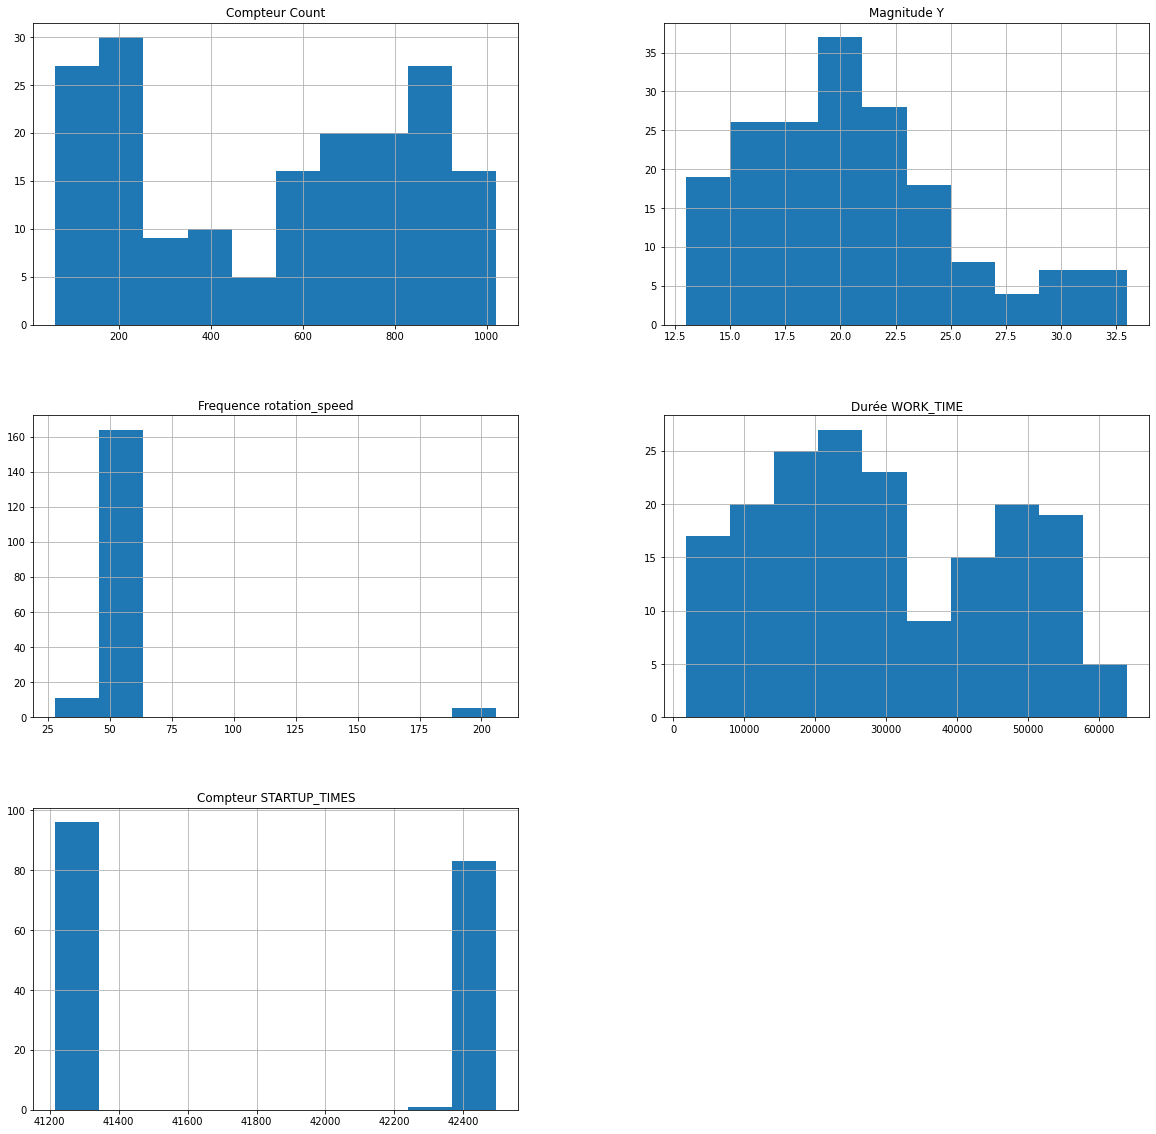

In [28]:
histogram = df_compteurs.hist(figsize = (20,20))
plt.show()

La distribution des variables n'est pas gaussienne. On n'appliquera donc pas de technique de prédiction supposant que la distribution est normale. 
Donc le Z-Score n'est pas le plus approprié pour détecter les outliers. On va utiliser un algorithme de clustering non supervisé : K-means.

## KMeans from sklearn

Import de la fonction.

In [29]:
kmeans = KMeans(n_clusters=4, random_state=42)

Détermination du nombre de clusters à créer grâce à la méthode du coude et de la silhouette. La méthode de la silhouette permet d'évaluer la densité des clusters et à quel point ils sont bien séparés. Le score est calculé selon la distance entre les points d'un même cluster et la distance avec le cluster le plus proche. Il a une valeur entre -1 et 1. Un score de 0 indique que les clusters se chevauchent et un score de 1 indique qu'ils sont denses et bien séparés.  
On se base sur toutes les mesures de vibration ("Vibration TOTAL").  


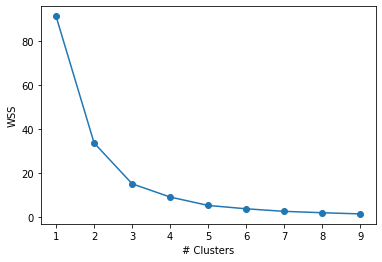

In [30]:
# Méthode du coude
cluster_range = range(1, 10)
cluster_wss = []
for num_cluster in cluster_range:
    clusters = KMeans(num_cluster)
    clusters.fit(df_donnees[['Vibration TOTAL']])
    cluster_wss.append(clusters.inertia_)
    
plt.xlabel('# Clusters')
plt.ylabel('WSS')
plt.plot(cluster_range, cluster_wss, marker = 'o')
plt.show()

In [31]:
# Méthode de la silhouette
ncluster_silhouette = []

for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit_predict(df_donnees[['Vibration TOTAL']])
    score = sklearn.metrics.silhouette_score(df_donnees[['Vibration TOTAL']], kmeans.labels_, metric='euclidean')
    ncluster_silhouette.append(score)
    print (f"Silhouette score for k(clusters) = {i} is {score}")

Silhouette score for k(clusters) = 2 is 0.5507743530143786
Silhouette score for k(clusters) = 3 is 0.5823551967607307
Silhouette score for k(clusters) = 4 is 0.5897770985133113
Silhouette score for k(clusters) = 5 is 0.5841778440004022
Silhouette score for k(clusters) = 6 is 0.5652563355287803
Silhouette score for k(clusters) = 7 is 0.579296257870074
Silhouette score for k(clusters) = 8 is 0.5677375060888176
Silhouette score for k(clusters) = 9 is 0.5968496007604364


In [32]:
def get_best_k_with_silhouette(ncluster_silhouette):
    for i in range(len(ncluster_silhouette)):
        if (i > 0) and (ncluster_silhouette[i] > ncluster_silhouette[i-1]) and (ncluster_silhouette[i] > ncluster_silhouette[i+1]):
            k_opti = i + 2
            return k_opti
            break
    return 0

k_opti = get_best_k_with_silhouette(ncluster_silhouette)
print(f'Optimal # of clusters for our data based on silhouette method: {k_opti}')

Optimal # of clusters for our data based on silhouette method: 4


In [33]:
# Entrainement de l'algorithme K-Means avec le nombre de cluster optimal et selon la valeur de vibration totale.
kmeans = KMeans(n_clusters=k_opti, random_state=42)
df_donnees['cluster'] = kmeans.fit_predict(df_donnees[['Vibration TOTAL']])

In [34]:
def plot_clusters(dict_c_mesu):
    tot = len(dict_c_mesu)
    cols = 2
    rows = tot //cols
    rows += tot % cols
    pos = range(1, tot + 1)
    fig = plt.figure(figsize=(20, 20))
    for v, k in zip(df_donnees.columns, range(tot)):
        try:
            ax = fig.add_subplot(rows, cols, pos[k])
            ax = plt.scatter(df_donnees.index, df_donnees[v], c=df_donnees['cluster'], s=50, cmap='viridis')
            plt.title(v, loc='center')
        except:
            pass
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)
    plt.show()
        

Représentation graphique des données selon le cluster qui leur a été attribué.

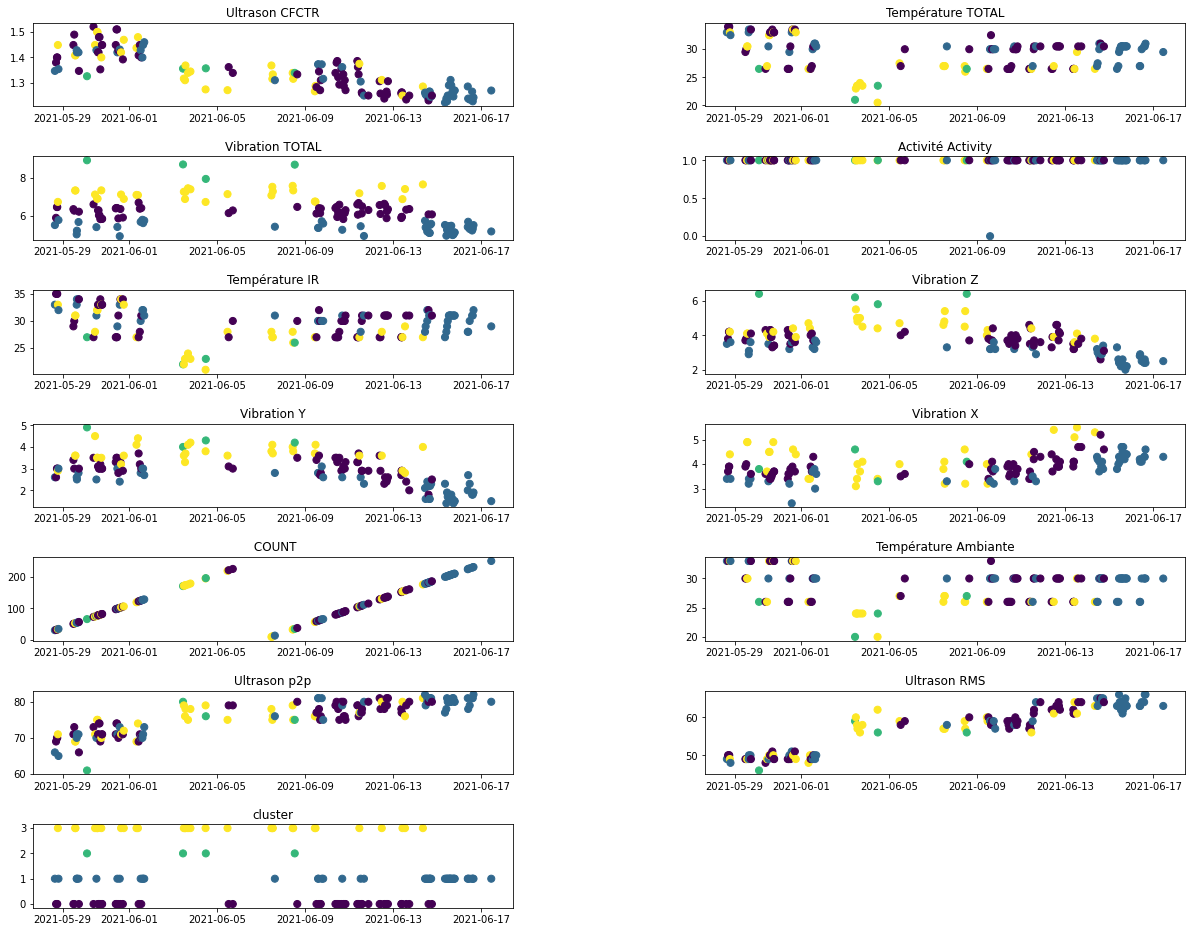

In [35]:
plot_clusters(dict_c_mesu)

## TESTS

In [36]:
clusters = df_donnees['cluster'].value_counts().copy()
clusters = clusters.sort_values(ascending=False)
clusters = clusters.reset_index()
clusters['cluster'].sum()
index = 0
nb_points = 0
for i in range(len(clusters)):
    if(nb_points < clusters['cluster'].sum()*0.75):
        nb_points += clusters.loc[i, 'cluster']
    else:
        index = clusters.loc[i, 'index']

print(f'index: {index}')

index: 2


In [37]:
cluster1 = clusters.loc[index-1, :]
cluster2 = clusters.loc[index, :]

mean_cluster1 = df_donnees[df_donnees['cluster'] == cluster1['index']]['Vibration TOTAL'].mean()
mean_cluster2 = df_donnees[df_donnees['cluster'] == cluster2['index']]['Vibration TOTAL'].mean()

if (mean_cluster1 > mean_cluster2):
    max_vib = df_donnees[df_donnees['cluster'] == cluster1['index']]['Vibration TOTAL'].max()
    min_vib = df_donnees[df_donnees['cluster'] == cluster2['index']]['Vibration TOTAL'].min()
else:
    max_vib = df_donnees[df_donnees['cluster'] == cluster2['index']]['Vibration TOTAL'].max()
    min_vib = df_donnees[df_donnees['cluster'] == cluster1['index']]['Vibration TOTAL'].min()

print(f'Min: {min_vib}, max: {max_vib}, mean:{mean_cluster1}, {mean_cluster2}')

Min: 4.94773, max: 7.65049, mean:5.383724791666668, 7.1685256666666675


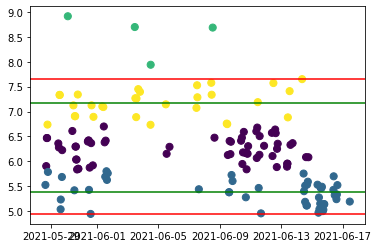

In [38]:
plt.scatter(df_donnees.index, df_donnees['Vibration TOTAL'], c=df_donnees['cluster'], s=50, cmap='viridis')
plt.axhline(y=max_vib, color='r')
plt.axhline(y=min_vib, color='r')
plt.axhline(y=mean_cluster1, color='g')
plt.axhline(y=mean_cluster2, color='g')

In [39]:
class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        
    def euclidian_dist(centroids):
        distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
        return distances
    
    def fit(self, data):
        self.centroids = {}
        
        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iter):
            self.classifications = {}
            
            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification], axis=0)

            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    optimized = False

            if optimized:
                break

    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification          

In [40]:
custom_kmeans = K_Means(k=4)
custom_kmeans.fit(df_donnees[['Vibration TOTAL']].to_numpy())

C:\Users\Juliette\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Juliette\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [41]:
import numpy as np
import pylab as plt

In [42]:
df_donnees.head(15)

,Ultrason CFCTR,Température TOTAL,Vibration TOTAL,Activité Activity,Température IR,Vibration Z,Vibration Y,Vibration X,COUNT,Température Ambiante,Ultrason p2p,Ultrason RMS,cluster
D_Vale,,,,,,,,,,,,,
2021-05-28 15:34:41,1.34694,33.0,5.52901,1.0,33.0,3.5,2.6,3.4,31.0,33.0,66.0,49.0,1
2021-05-28 16:49:41,1.38000,34.0,5.90678,1.0,35.0,3.8,2.6,3.7,32.0,33.0,69.0,50.0,0
2021-05-28 17:49:42,1.40000,34.0,6.46916,1.0,35.0,4.2,3.0,3.9,33.0,33.0,70.0,50.0,0
2021-05-28 18:09:42,1.40000,34.0,6.46916,1.0,35.0,4.2,3.0,3.9,33.0,33.0,70.0,50.0,0
2021-05-28 18:49:42,1.44898,33.0,6.73869,1.0,33.0,4.2,2.9,4.4,34.0,33.0,71.0,49.0,3
2021-05-28 19:29:42,1.35417,32.5,5.78965,1.0,32.0,3.6,3.0,3.4,35.0,33.0,65.0,48.0,1
2021-05-29 11:44:45,1.44898,29.5,6.36082,1.0,29.0,3.7,3.4,3.9,51.0,30.0,71.0,49.0,0
2021-05-29 12:39:45,1.48980,30.0,6.28013,1.0,30.0,3.8,3.0,4.0,52.0,30.0,73.0,49.0,0
2021-05-29 13:39:45,1.40816,30.5,7.33348,1.0,31.0,4.1,3.6,4.9,53.0,30.0,69.0,49.0,3


In [79]:
import numpy as np
 
# store vertices in list
vertices = round(df_donnees['Vibration TOTAL'], 1).to_list()
# store edges in list
edges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 5), (8, 6)]
edges = []
for i in range(len(vertices)):
    edges.append((i, i + 1))

#print(edges)
# create an integer numpy array with all values initialized to zero of the size of our edges
adjacencyMatrix = np.zeros((len(edges) + 1, len(edges) + 1)).astype(int)
len(adjacencyMatrix)
len(edges)
print(adjacencyMatrix[142][1])

0


In [80]:
# Represent edges in the adjacency matrix
for edge in edges:
    v1 = edge[0]
    v2 = edge[1]
    adjacencyMatrix[v1][v2] = 1
    adjacencyMatrix[v2][v1] = 1 # if v1 is connected to v2, v2 is also connected to v1

In [81]:
print(f'Noeuds du graphe :\n{vertices}')
print(f'Arêtes du graphe :\n{edges}')
print(f"Matrice d'adjacence : {adjacencyMatrix}")

Noeuds du graphe :
[5.5, 5.9, 6.5, 6.5, 6.7, 5.8, 6.4, 6.3, 7.3, 7.3, 5.0, 5.2, 5.7, 6.2, 8.9, 6.6, 7.1, 5.4, 6.9, 6.9, 6.3, 6.3, 6.0, 6.0, 5.8, 7.3, 5.9, 5.9, 6.4, 6.4, 6.4, 5.4, 5.9, 4.9, 6.4, 7.1, 5.9, 6.9, 7.1, 7.1, 6.7, 6.4, 5.7, 6.4, 5.8, 5.6, 5.8, 8.7, 7.3, 6.9, 7.3, 7.4, 7.4, 6.7, 7.9, 7.1, 6.2, 6.3, 7.1, 7.5, 7.3, 5.4, 7.6, 7.3, 8.7, 6.5, 6.8, 6.7, 6.1, 5.4, 5.4, 6.4, 6.1, 6.4, 5.7, 5.6, 6.4, 6.5, 5.9, 6.2, 6.6, 6.2, 5.3, 5.8, 6.2, 6.2, 6.3, 6.6, 6.1, 6.7, 7.2, 5.5, 6.1, 6.5, 5.0, 6.3, 6.6, 6.1, 7.6, 6.6, 6.6, 5.9, 6.3, 6.4, 5.9, 6.0, 6.0, 6.9, 7.4, 6.3, 6.4, 7.7, 5.8, 5.4, 5.2, 5.5, 6.1, 5.1, 5.1, 5.5, 5.6, 6.1, 5.5, 5.0, 5.3, 5.0, 5.2, 5.5, 5.5, 5.5, 5.5, 5.0, 5.0, 5.1, 5.1, 5.4, 5.7, 5.3, 5.2, 5.3, 5.5, 5.2]
Arêtes du graphe :
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27),

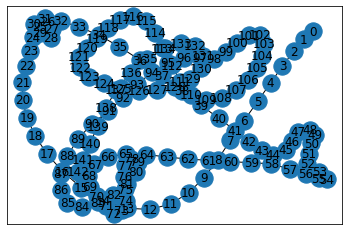

In [82]:
import networkx as nx
G=nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos)
plt.show()

In [88]:
# how many points in graph? x points
MATRIX_SIZE = len(vertices) + 1

# create matrix x*y
R = np.matrix(np.ones(shape=(MATRIX_SIZE, MATRIX_SIZE)))
R *= -1

In [89]:
goal = round(df_donnees['Vibration TOTAL'].mean(), 1)
goal = vertices.index(goal)

In [90]:
for point in edges:
    #print(point)
    if point[1] == goal:
        R[point] = 100
    else:
        R[point] = 0

    if point[0] == goal:
        R[point[::-1]] = 100
    else:
        # reverse of point
        R[point[::-1]]= 0

# add goal point round trip
R[goal, goal] = 100

R

matrix([[-1.,  0., -1., ..., -1., -1., -1.],
        [ 0., -1.,  0., ..., -1., -1., -1.],
        [-1.,  0., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1.,  0., -1.],
        [-1., -1., -1., ...,  0., -1.,  0.],
        [-1., -1., -1., ..., -1.,  0., -1.]])

In [91]:
Q = np.matrix(np.zeros([MATRIX_SIZE, MATRIX_SIZE]))
# learning parameter
gamma = 0.8

initial_state = 1

def available_actions(state):
    current_state_row = R[state,]
    av_act = np.where(current_state_row >= 0)[1]
    return av_act

available_act = available_actions(initial_state) 

def sample_next_action(available_actions_range):
    next_action = int(np.random.choice(available_act,1))
    return next_action

action = sample_next_action(available_act)

def update(current_state, action, gamma):
    
  max_index = np.where(Q[action,] == np.max(Q[action,]))[1]
  
  if max_index.shape[0] > 1:
      max_index = int(np.random.choice(max_index, size = 1))
  else:
      max_index = int(max_index)
  max_value = Q[action, max_index]
  
  Q[current_state, action] = R[current_state, action] + gamma * max_value
  #print('max_value', R[current_state, action] + gamma * max_value)
  
  if (np.max(Q) > 0):
    return(np.sum(Q/np.max(Q)*100))
  else:
    return (0)
    
update(initial_state, action, gamma)

0

In [92]:
# Training
scores = []
for i in range(700):
    current_state = np.random.randint(0, int(Q.shape[0]))
    available_act = available_actions(current_state)
    action = sample_next_action(available_act)
    score = update(current_state,action,gamma)
    scores.append(score)
    #print ('Score:', str(score))
    
print("Trained Q matrix:")
print(Q/np.max(Q)*100)

Trained Q matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Most efficient path:
[0, 138, 130, 103, 54, 2, 6, 137, 3, 65, 128, 78, 63, 103, 138, 133, 13]


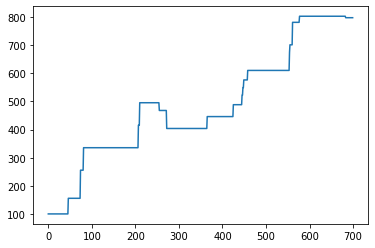

In [93]:
# Testing
current_state = 0
steps = [current_state]

while current_state != goal:

    next_step_index = np.where(Q[current_state,] == np.max(Q[current_state,]))[1]
    
    if next_step_index.shape[0] > 1:
        next_step_index = int(np.random.choice(next_step_index, size = 1))
    else:
        next_step_index = int(next_step_index)
    
    steps.append(next_step_index)
    current_state = next_step_index

print("Most efficient path:")
print(steps)

plt.plot(scores)
plt.show()

In [96]:
print('Vibration values:')
for step in steps:
    print(f'{vertices[step]}')

Vibration values:
5.5
5.2
5.5
6.4
7.9
6.5
6.4
5.3
6.5
6.5
5.5
5.9
7.3
6.4
5.2
5.1
6.2


In [ ]:
import numpy as np

# R matrix
R = np.matrix([ [-1,-1,-1,-1,0,-1],
		[-1,-1,-1,0,-1,100],
		[-1,-1,-1,0,-1,-1],
		[-1,0,0,-1,0,-1],
		[-1,0,0,-1,-1,100],
		[-1,0,-1,-1,0,100] ])

# Q matrix
Q = np.matrix(np.zeros([6,6]))

# Gamma (learning parameter).
gamma = 0.8

# Initial state. (Usually to be chosen at random)
initial_state = 1

# This function returns all available actions in the state given as an argument
def available_actions(state):
    current_state_row = R[state,]
    av_act = np.where(current_state_row >= 0)[1]
    return av_act

# Get available actions in the current state
available_act = available_actions(initial_state) 

# This function chooses at random which action to be performed within the range 
# of all the available actions.
def sample_next_action(available_actions_range):
    next_action = int(np.random.choice(available_act,1))
    return next_action

# Sample next action to be performed
action = sample_next_action(available_act)

# This function updates the Q matrix according to the path selected and the Q 
# learning algorithm
def update(current_state, action, gamma):
    
    max_index = np.where(Q[action,] == np.max(Q[action,]))[1]

    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size = 1))
    else:
        max_index = int(max_index)
    max_value = Q[action, max_index]
    
    # Q learning formula
    Q[current_state, action] = R[current_state, action] + gamma * max_value

# Update Q matrix
update(initial_state,action,gamma)

#-------------------------------------------------------------------------------
# Training

# Train over 10 000 iterations. (Re-iterate the process above).
for i in range(10000):
    current_state = np.random.randint(0, int(Q.shape[0]))
    available_act = available_actions(current_state)
    action = sample_next_action(available_act)
    update(current_state,action,gamma)
    
# Normalize the "trained" Q matrix
print("Trained Q matrix:")
print(Q/np.max(Q)*100)

#-------------------------------------------------------------------------------
# Testing

# Goal state = 5
# Best sequence path starting from 2 -> 2, 3, 1, 5

current_state = 2
steps = [current_state]

while current_state != 5:

    next_step_index = np.where(Q[current_state,] == np.max(Q[current_state,]))[1]
    
    if next_step_index.shape[0] > 1:
        next_step_index = int(np.random.choice(next_step_index, size = 1))
    else:
        next_step_index = int(next_step_index)
    
    steps.append(next_step_index)
    current_state = next_step_index

# Print selected sequence of steps
print("Selected path:")
print(steps)

Trained Q matrix:
[[  0.    0.    0.    0.   80.    0. ]
 [  0.    0.    0.   64.    0.  100. ]
 [  0.    0.    0.   64.    0.    0. ]
 [  0.   80.   51.2   0.   80.    0. ]
 [  0.   80.   51.2   0.    0.  100. ]
 [  0.   80.    0.    0.   80.  100. ]]
Selected path:
[2, 3, 4, 5]
